In [14]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml
import pickle

In [2]:
sspp = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinesspplamostlrsmilliquas.csv',
                   usecols=["CaHK_0_p","pmra_1_p","pmdec_1_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
                            "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","AFE_s","FEH_ADOP_s","RA_q"])
sspp.FEH_ADOP_s.value_counts()

-9999.000000    72482
-0.970938          18
-1.623412           4
-1.229497           4
-0.572936           4
                ...  
-0.712517           1
-0.535879           1
-0.693920           1
-0.543458           1
-0.124109           1
Name: FEH_ADOP_s, Length: 37961, dtype: int64

In [3]:
sspp = sspp.loc[(sspp["g_chp_psf_p"] < 1e19) & (sspp["r_chp_psf_p"] < 1e19) & (sspp["i_chp_psf_p"] < 1e19) & \
                        (sspp["z_chp_psf_p"] < 1e19) & (sspp["y_chp_psf_p"] < 1e19) & (sspp["MAG_AUTO_p"] < 95) & \
                        (np.isnan(sspp["pmra_1_p"]) == False) & (np.isnan(sspp["pmdec_1_p"]) == False) & \
                        (np.isnan(sspp["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sspp["phot_bp_mean_mag_1_p"]) == False) & \
                        (np.isnan(sspp["phot_rp_mean_mag_1_p"]) == False) & (np.isnan(sspp['RA_q']) == True)]
sspp.FEH_ADOP_s.value_counts()

-9999.000000    12704
-0.970938          18
-1.832760           4
-1.482822           4
-2.234864           4
                ...  
-0.508577           1
-0.527734           1
-0.489074           1
-0.139976           1
-0.124109           1
Name: FEH_ADOP_s, Length: 37563, dtype: int64

In [4]:
bins = np.linspace(np.min(sspp['FEH_ADOP_s'][sspp['FEH_ADOP_s']>-9000]),np.max(sspp['FEH_ADOP_s'])+0.000001,1001)
# bins

In [5]:
for i in range(len(bins)-1):
    # print(sspp['FEH_ADOP_s'].values[(sspp['FEH_ADOP_s'] >= bins[i]) & (sspp['FEH_ADOP_s'] < bins[i+1])])
    # break
    if len(sspp['FEH_ADOP_s'][(sspp['FEH_ADOP_s'] >= bins[i]) & (sspp['FEH_ADOP_s'] < bins[i+1])]) == 0:
        next
    else:
        # print(len(sspp['FEH_ADOP_s'][(sspp['FEH_ADOP_s'] >= bins[i]) & (sspp['FEH_ADOP_s'] < bins[i+1])]))
        sspp = sspp.replace({'FEH_ADOP_s': sspp['FEH_ADOP_s'].values[(sspp['FEH_ADOP_s'] >= bins[i]) & (sspp['FEH_ADOP_s'] < bins[i+1])]},i)
    # print(sspp['FEH_ADOP_s'][(sspp['FEH_ADOP_s'] >= bins[i]) & (sspp['FEH_ADOP_s'] < bins[i+1])])
    if i%100 == 0:
        print('bin',i,'/1000')
sspp = sspp.replace({'FEH_ADOP_s':[np.nan,-9999.]}, -1)
sspp.FEH_ADOP_s.value_counts()
# sspp

bin 0 /1000
bin 100 /1000
bin 200 /1000
bin 300 /1000
bin 400 /1000
bin 500 /1000
bin 600 /1000
bin 700 /1000
bin 800 /1000
bin 900 /1000


-1.0      3611223
 738.0        200
 746.0        194
 745.0        193
 739.0        191
           ...   
 256.0          1
 166.0          1
 32.0           1
 263.0          1
 304.0          1
Name: FEH_ADOP_s, Length: 779, dtype: int64

In [6]:
# New method where I don't(?) reindex and see what happens.
df_joined = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
                   'PMDec': sspp['pmdec_1_p'],
                   'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
                   'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
                   'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
                   'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
                   'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
                   'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
                   'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
                   'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
                   'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']}))
df2 = pd.DataFrame({'feh': sspp['FEH_ADOP_s']})

In [7]:
df2.shape

(3649568, 1)

In [8]:
# old method tht needed me to re-drop the nans
# df_joined = vaex.from_pandas(pd.DataFrame({'PMRA': sspp['pmra_1_p'],
#                    'PMDec': sspp['pmdec_1_p'],
#                    'G_gaia': sspp["CaHK_0_p"]-sspp['phot_g_mean_mag_1_p'],
#                    'B_gaia': sspp["CaHK_0_p"]-sspp['phot_bp_mean_mag_1_p'],
#                    'R_gaia': sspp["CaHK_0_p"]-sspp['phot_rp_mean_mag_1_p'],
#                    'G_pan': sspp["CaHK_0_p"]-sspp['g_chp_psf_p'],
#                    'R_pan': sspp["CaHK_0_p"]-sspp['r_chp_psf_p'],
#                    'I_pan': sspp["CaHK_0_p"]-sspp['i_chp_psf_p'],
#                    'Z_pan': sspp["CaHK_0_p"]-sspp['z_chp_psf_p'],
#                    'Y_pan': sspp["CaHK_0_p"]-sspp['y_chp_psf_p'],
#                    'AUTO_cfis': sspp["CaHK_0_p"]-sspp['MAG_AUTO_p']},
#                    index=np.arange(0,len(sspp))))
# df2 = pd.DataFrame({'feh': sspp['FEH_ADOP_s']}, index = np.arange(0,len(sspp)))

In [9]:
df2.feh.value_counts()

-1.0      3611223
 738.0        200
 746.0        194
 745.0        193
 739.0        191
           ...   
 256.0          1
 166.0          1
 32.0           1
 263.0          1
 304.0          1
Name: feh, Length: 779, dtype: int64

In [10]:
print(df_joined.shape)
df_joined = df_joined.dropna()
print(df_joined.shape)
print(df2.shape)
df2 = df2.dropna()
print(df2.shape)

(3649568, 11)
(3649568, 11)
(3649568, 1)
(3649568, 1)


In [11]:
scaled_star_data = StandardScaler().fit_transform(df_joined)

In [12]:
%%time
fitter = umap.UMAP(verbose=True,n_epochs=200,min_dist=0.0).fit(scaled_star_data, y=df2['feh'])
embedding = fitter.embedding_

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, n_epochs=200, verbose=True)
Construct fuzzy simplicial set
Thu Jan 27 06:00:12 2022 Finding Nearest Neighbors
Thu Jan 27 06:00:12 2022 Building RP forest with 64 trees
Thu Jan 27 06:01:34 2022 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Thu Jan 27 06:06:31 2022 Finished Nearest Neighbor Search
Thu Jan 27 06:07:42 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jan 27 08:00:13 2022 Finished embedding
CPU times: user 1d 4h 8min 25s, sys: 35min 38s, total: 1d 4h 44min 3s
Wall time: 2h 4s


In [15]:
redu = pickle.dumps(fitter)
filename = 'semisupervisedmetalpickle.obj'

with open(filename,'wb') as file_object:
    file_object.write(redu)

Thu Jan 27 08:13:30 2022 Worst tree score: 0.85905318
Thu Jan 27 08:13:30 2022 Mean tree score: 0.85957294
Thu Jan 27 08:13:30 2022 Best tree score: 0.85999521
Thu Jan 27 08:14:29 2022 Forward diversification reduced edges from 54743520 to 22376759
Thu Jan 27 08:14:41 2022 Reverse diversification reduced edges from 22376759 to 22376757
Thu Jan 27 08:14:46 2022 Degree pruning reduced edges from 22838522 to 22838522
Thu Jan 27 08:14:46 2022 Resorting data and graph based on tree order
Thu Jan 27 08:14:51 2022 Compressing index by removing unneeded attributes
Thu Jan 27 08:14:52 2022 Building and compiling search function


In [16]:
mask = df2['feh'] != -1

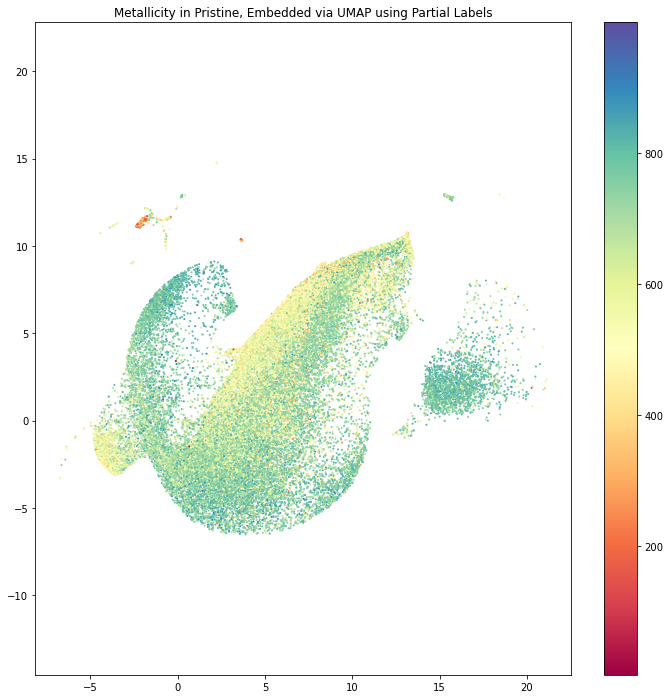

In [17]:
fig, ax = plt.subplots(figsize=(12,12));
cax = ax.scatter(embedding[:,0][mask],embedding[:,1][mask], s=1, c=df2['feh'][mask], cmap='Spectral', alpha=1.0);
ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax)
ax.set_title("Metallicity in Pristine, Embedded via UMAP using Partial Labels");
plt.savefig('/arc/home/aydanmckay/seminounknownsmetallabelswrongbarmindist0hmmm.png')

In [18]:
# df2 = pd.DataFrame({'feh': sspp['FEH_ADOP_s']}, index = np.arange(0,len(sspp)))
# df2.feh.value_counts()

In [19]:
# print(df2.shape)
# df2 = df2.dropna()
# print(df2.shape)

In [20]:
for i in range(len(bins)-1):
    if len(df2[mask].values[df2[mask] == i]) > 0:
        df2[mask] = df2[mask].replace({'feh': i},(bins[i+1]+bins[i])/2)
df2.feh.value_counts()

-1.000000    3611223
-0.596113        200
-0.555159        194
-0.560278        193
-0.590994        191
              ...   
-3.063588          1
-3.524320          1
-4.210298          1
-3.027753          1
-2.817864          1
Name: feh, Length: 779, dtype: int64

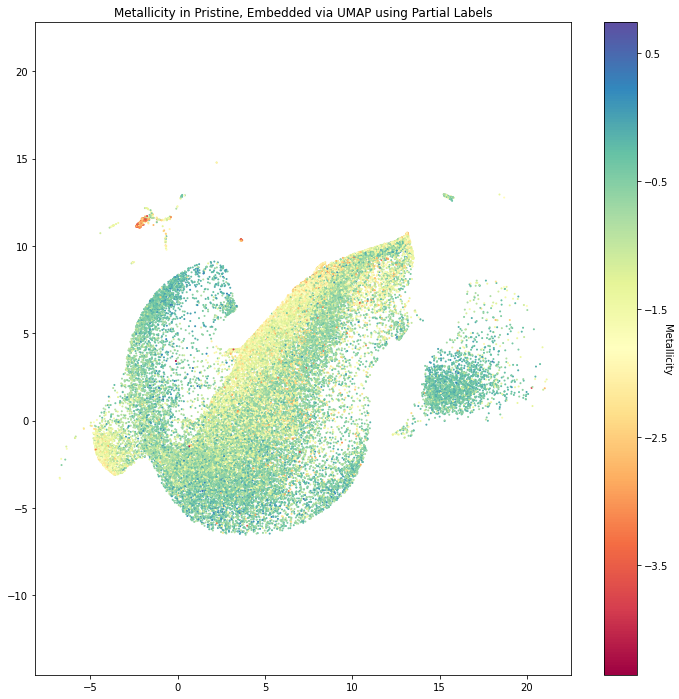

In [21]:
fig, ax = plt.subplots(figsize=(12,12));
cax = ax.scatter(embedding[:,0][mask],embedding[:,1][mask], s=1, c=df2['feh'][mask], cmap='Spectral', alpha=1.0);
ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, ticks=[0.5, -0.5, -1.5, -2.5, -3.5])
cbar.set_label('Metallicity', rotation=270)
ax.set_title("Metallicity in Pristine, Embedded via UMAP using Partial Labels");
plt.savefig('/arc/home/aydanmckay/seminounknownsmetallabelsrightbarmindist0hmmm.png')